## Segmentation to line

### Import modules and define set variables

In [1]:
import linescanning
from linescanning.bin.utils.utils import format_graph
import os
import sys
import nibabel as nb
import numpy as np
import pandas as pd
import pathlib
from bids import BIDSLayout
from nilearn import image
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
warnings.filterwarnings("ignore")
np.set_printoptions(precision=3, suppress=True)

In [2]:
subject = 'sub-005'
opj = os.path.join

hemi = "left"

if hemi == "left":
    idx = 0
    tag = "L"
elif hemi == "right":
    idx = 1
    tag = "R"

In [3]:
base, place = linescanning.utils.get_base_dir()

proj = opj(base, 'projects', 'hemifield')
prog = opj(base, 'programs', 'linescanning')

nighres = opj(proj, 'derivatives', 'nighres', subject)
tissue = opj(nighres, 'ses-1', 'cruise')
layers = opj(nighres, 'ses-1', 'layering')

In [4]:
cortex

'/data1/projects/MicroFunc/Jurjen/projects/hemifield/derivatives/pycortex/sub-005'

### Warp segmentations to slice (= line space)

In [29]:
# warp session 1 files to slice resolution via session 1 to session 2 warp file (only 1 interpolation!)
import pickle
base, place = linescanning.utils.get_base_dir()
proj = opj(base, 'projects', 'hemifield')
subj = ['001','003','004','005','006']

for ii in subj:

    print(f"\n----------------------- sub-{ii} -----------------------")

    subject = f'sub-{ii}'
    outdir = opj(proj, 'derivatives', 'nighres', subject, 'ses-2') 
    pathlib.Path(outdir).mkdir(parents=True, exist_ok=True)
    cortex = opj(proj, 'derivatives', 'pycortex', subject)
    masks = opj(proj, 'derivatives', 'manual_masks', subject, 'ses-1')

    #####################################################################################################################################
    # FETCH FILES

    # Fetch PVE/layers/depth files from session 1
    try:
        tissue_f = linescanning.utils.get_file_from_substring("cortex.nii.gz", opj(outdir.replace('ses-2', 'ses-1'), 'cruise'))
        layers_f = linescanning.utils.get_file_from_substring("layers.nii.gz", opj(outdir.replace('ses-2', 'ses-1'), 'layering'))
        depth_f  = linescanning.utils.get_file_from_substring("depth.nii.gz", opj(outdir.replace('ses-2', 'ses-1'), 'layering'))
    except:
        raise FileNotFoundError("could not find layer and/or tissue image")
        
    tissue_img  = nb.load(tissue_f)
    layers_img  = nb.load(layers_f)
    depth_img = nb.load(depth_f)

    # Fetch wm/gm/csf probability files from session 1
    try:
        wm_f  = linescanning.utils.get_file_from_substring("label-WM", masks)
        gm_f  = linescanning.utils.get_file_from_substring("label-GM", masks)
        csf_f = linescanning.utils.get_file_from_substring("label-CSF", masks)
        mask  = linescanning.utils.get_file_from_substring("spm_mask", masks)
    except:
        raise FileNotFoundError("could not find tissue probability images")
        
    wm_img  = nb.load(wm_f)
    gm_img  = nb.load(gm_f)
    csf_img = nb.load(csf_f)

    #####################################################################################################################################
    # RESAMPLE TO SLICE

    try:
        slc = linescanning.utils.get_file_from_substring("1slice_run-1_T1w.nii.gz", opj(proj, subject, 'ses-2', 'anat'))
    except:
        raise FileNotFoundError(f"could not find slice-file in {opj(proj, subject, 'ses-2', 'anat')}")
        
    try:
        warp_file = linescanning.utils.get_file_from_substring("from-ses1_to-ses2", opj(cortex, 'transforms'))
    except:
        try:
            os.system(f"call_ses1_to_ses2 {subject}")
            warp_file = linescanning.utils.get_file_from_substring("from-ses1_to-ses2", opj(cortex, 'transforms'))
        except:
            raise FileNotFoundError(f"could not find warp-file in {opj(os.environ['CTX'], 'transforms')}")

    # collect them in 'resampled' dictionary (in brackets is file suffixes)
    #  0 = wm prob  ("cruise-pwm")
    #  1 = gm prob  ("cruise-pgm")
    #  2 = csf prob ("cruise-pcsf")
    #  3 = pve      ("cruise-cortex")
    #  4 = layers   ("layering-layers")
    #  5 = depth    ("layering-depth")

    in_type = ['prob', 'prob', 'prob', 'tissue', 'layer', 'prob', 'tissue']
    tag = ['wm', 'gm', 'csf', 'cortex', 'layers', 'depth', 'mask']
    resampled = {}
    for n,f in enumerate([wm_f, gm_f, csf_f, tissue_f, layers_f, depth_f, mask]):
        
        # fn_parts = f.split(os.sep)[-1].split('_')
        # idx_acq = [(i, fn_parts.index('acq-')) for i, fn_parts in enumerate(fn_parts) if 'acq-' in fn_parts][0][0]
        # fn_parts[idx_acq] = 'acq-1slice' # replace acquisition with '1slice'

        # replace acq-MP2RAGE with acq-1slice
        new_fn = linescanning.utils.replace_string(f,"acq-MP2RAGE", "acq-1slice")
        new_file = opj(outdir, os.path.basename(new_fn))
        
        if not os.path.exists(new_file):
            print('warping {} to slice (= line space)'.format(os.path.basename(f)))
            if in_type[n] == "tissue":
                # Use MultiLabel-interpolation for tissue-segmentation
                linescanning.transform.ants_applytrafo(slc, f, interp="mul", trafo=warp_file, output=new_file)
            elif in_type[n] == "layer":
                # Use GenericLabel-interpolation for layer-segmentation
                linescanning.transform.ants_applytrafo(slc, f, interp="gen", trafo=warp_file, output=new_file)
            else:
                # Use nearest neighbor-interpolation for probability maps
                linescanning.transform.ants_applytrafo(slc, f, trafo=warp_file, output=new_file)
            
        else:
            print('{} already exists'.format(os.path.basename(new_file)))
            
        resampled[tag[n]] = new_file

    #####################################################################################################################################
    # SAVE IN PICKLE FILE

    f = open(opj(outdir, f'{subject}_space-ses2_desc-segmentations.pkl'), "wb")
    pickle.dump(resampled, f)
    f.close()


----------------------- sub-001 -----------------------
sub-001_ses-1_acq-1slice_label-WM_probseg.nii.gz already exists
sub-001_ses-1_acq-1slice_label-GM_probseg.nii.gz already exists
sub-001_ses-1_acq-1slice_label-CSF_probseg.nii.gz already exists
sub-001_ses-1_acq-1slice_desc-cruise_cortex.nii.gz already exists
sub-001_ses-1_acq-1slice_desc-layering_layers.nii.gz already exists
sub-001_ses-1_acq-1slice_desc-layering_depth.nii.gz already exists
sub-001_ses-1_acq-1slice_desc-spm_mask.nii.gz already exists

----------------------- sub-003 -----------------------
sub-003_ses-1_acq-1slice_label-WM_probseg.nii.gz already exists
sub-003_ses-1_acq-1slice_label-GM_probseg.nii.gz already exists
sub-003_ses-1_acq-1slice_label-CSF_probseg.nii.gz already exists
sub-003_ses-1_acq-1slice_desc-cruise_cortex.nii.gz already exists
sub-003_ses-1_acq-1slice_desc-layering_layers.nii.gz already exists
sub-003_ses-1_acq-1slice_desc-layering_depth.nii.gz already exists
warping sub-003_ses-1_acq-MP2RAGE_des

In [28]:
resampled

{'wm': '/mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/nighres/sub-006/ses-2/sub-006_ses-1_acq-1slice_label-WM_probseg.nii.gz',
 'gm': '/mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/nighres/sub-006/ses-2/sub-006_ses-1_acq-1slice_label-GM_probseg.nii.gz',
 'csf': '/mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/nighres/sub-006/ses-2/sub-006_ses-1_acq-1slice_label-CSF_probseg.nii.gz',
 'cortex': '/mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/nighres/sub-006/ses-2/sub-006_ses-1_acq-1slice_desc-cruise_cortex.nii.gz',
 'layers': '/mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/nighres/sub-006/ses-2/sub-006_ses-1_acq-1slice_desc-layering_layers.nii.gz',
 'depth': '/mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/nighres/sub-006/ses-2/sub-006_ses-1_acq-1slice_desc-layering_depth.nii.gz',
 'mask': '/mnt/d/FSL/shared/spinoza/projects/hemifield/derivatives/nighres/sub-006/ses-2/sub-006_ses-1_acq-1slice_desc-spm_mask.nii.gz'}

### Select middle row of values representing the line

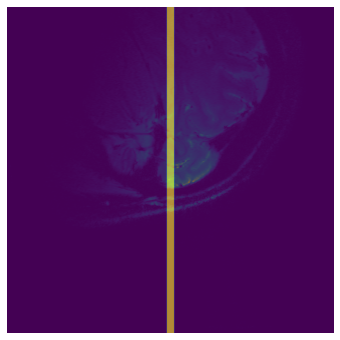

In [27]:
subject = 'sub-003'

slc = linescanning.utils.get_file_from_substring("1slice_run-1_T1w.nii.gz", opj(proj, subject, 'ses-2', 'anat'))

# artifact from older version
resampled_wm  = nb.load(resampled['wm'])
resampled_gm  = nb.load(resampled['gm'])
resampled_csf = nb.load(resampled['csf'])

# select line nifti
# line_fn = BIDSLayout(opj(proj, subject), validate=False).get(session=2, datatype='func', run=7,extension=['nii', 'nii.gz'], return_type='file')

line_fn = linescanning.image.create_line_from_slice(slc)
line_data = line_fn.get_fdata()

fig = plt.figure(frameon=False, figsize=(15,6))
im1 = plt.imshow(np.squeeze(nb.load(slc).get_fdata()))
im2 = plt.imshow(np.squeeze(line_data),alpha=0.6)
plt.axis('off')
plt.show()

In [10]:
# line_wm = np.multiply(np.squeeze(resampled_wm.get_fdata(),axis=3),line_data.astype(bool))

In [11]:
# nb.Nifti1Image(line_wm, affine=resampled_wm.affine, header=resampled_wm.header).to_filename(opj(proj, subject, 'ses-2', 'func', f'{subject}_ses-1_acq-MP2RAGE_space-beam_desc-pwm.nii.gz'))

In [28]:
beam = {}
for i in resampled:

    img = nb.load(resampled[i])

    if len(img.get_fdata().shape) == 4:
        img_d = np.squeeze(img.get_fdata(), axis=3)
    else:
        img_d = img.get_fdata()

    beam[i] = np.squeeze(np.multiply(img_d,line_data.astype(bool))[:,352:368]) # fetch middle 16 voxels and remove 3rd axis

In [29]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator

In [30]:
print(len(beam))

6


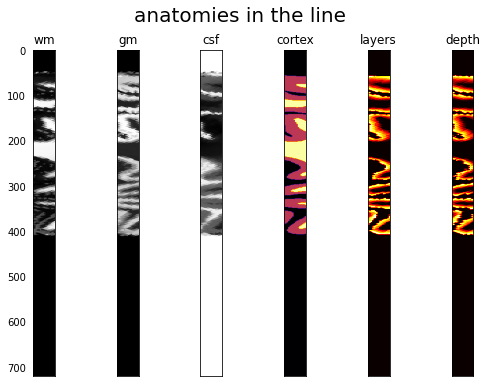

In [31]:
# https://stackoverflow.com/questions/12998430/remove-xticks-in-a-matplotlib-plot
fig, axs = plt.subplots(1,len(beam), figsize=(15, 6), facecolor='w', edgecolor='k', sharey=True)
fig.subplots_adjust(hspace=.5, wspace=-0.8)

fig.suptitle('anatomies in the line', fontsize=20)
axs = axs.ravel()

cmaps = ['Greys_r','Greys_r','Greys_r','inferno','hot','hot']

for i,r in enumerate(beam):
# anat = list(beam.keys())
    axs[i].set_title(r)
    axs[i].imshow(beam[r], aspect=1/3, cmap=cmaps[i])
    axs[i].set_xticks([])
    axs[i].yaxis.set_ticks_position('none')

In [33]:
prob_stack = np.dstack([beam['wm'], beam['gm'], beam['csf']])
prob_stack_avg = np.average(prob_stack, axis=1)
prob_stack_avg

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(prob_stack_avg)
avg_norm = scaler.transform(prob_stack_avg)

In [35]:
avg_norm[-10:,:]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [36]:
tissue = []
lut = {'wm':2,'gm':1,'csf':0}

# avg_norm has 3 columns; 1st = WM, 2nd = GM, 3rd = CSF
for i,r in enumerate(avg_norm):

    max_val = np.amax(avg_norm[i,:])

    # check tissue type only if non-zero value. If all probabilities are 0 is should be set to zero regardless
    if max_val == 0:
        tissue.append(lut['csf'])
    else:
        # make list of each row for nicer indexing
        idx = list(avg_norm[i,:]).index(max_val)
        if idx == 0:
            # type = 'wm' = '1' in nighres segmentation
            tissue.append(lut['wm'])
        elif idx == 1:
            # type = 'gm' = '2' in nighres segmentation
            tissue.append(lut['gm'])
        elif idx == 2:
            # type = 'csf' = '0' in nighres segmentation
            tissue.append(lut['csf'])

tissue = np.array(tissue)[:,np.newaxis]
tissue.shape

(720, 1)

In [37]:
from linescanning.pycortex import get_linerange
get_linerange(method="nighres", tissue=tissue)

[345, 349]

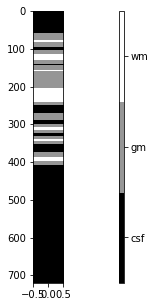

In [30]:
k = list(lut.keys())
k.reverse()
k
fig, ax = plt.subplots(figsize=(20,5))

plt.imshow(tissue,aspect=1/80,cmap=plt.cm.get_cmap('Greys_r', 3))
plt.colorbar(ticks=[1,2,0], format=plt.FuncFormatter(lambda val, loc: k[val]),aspect=60)
plt.clim(-0.5,2.5)

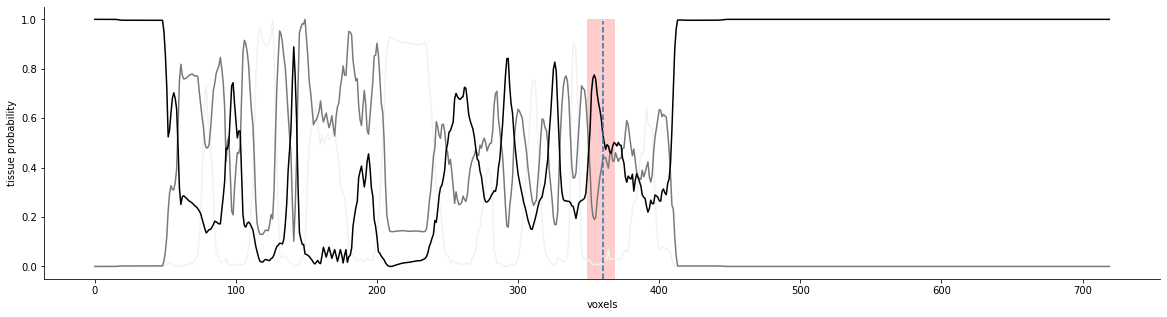

In [31]:
import matplotlib.patches as patches
import seaborn as sns

k = list(lut.keys())
# k.reverse()
# k

fig, ax = plt.subplots(figsize=(20,5))
color = sns.light_palette('black', avg_norm.shape[1])
# color[0],color[1] = color[1],color[0]
# color.reverse()

for i in np.arange(0,avg_norm.shape[-1]):
    plt.plot(avg_norm[:,i], color=color[i])

# red rectangle for middle 20 voxels
rect1 = patches.Rectangle((349,ax.axes.get_ylim()[0]),20,ax.axes.get_ylim()[1],linewidth=1,edgecolor=None,facecolor='r', alpha=0.2)
ax.add_patch(rect1)

# dashed line for center of line
plt.axvline(x=360,ymax=0.95, ls='--')
# plt.axis('off')
plt.xlabel('voxels')
plt.ylabel('tissue probability')
format_graph()
plt.show()

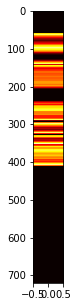

In [32]:
# can we get layers into the line?
layers_d = beam['layers']
layers_d[layers_d == 0] = np.nan # convert zeros to NaN
avg_layers = np.nanmean(layers_d, axis=1) # average by ignoring zeros
avg_layers = np.nan_to_num(avg_layers) # convert zeros back to NaN otherwise int() will fail

avg_layers = np.array([int(i) for i in avg_layers if np.isnan(i) == False])[:,np.newaxis]
# avg_layers.shape

fig, ax = plt.subplots(figsize=(20,5))

plt.imshow(avg_layers,aspect=1/80,cmap='hot')
# plt.colorbar(ticks=[2,1,0], format=plt.FuncFormatter(lambda val, loc: k[val]),aspect=60)
# plt.clim(-0.5,2.5)

In [35]:
# layer_img = opj(layers, 'layers_nan.nii.gz')
# linescanning.transform.ants_applytrafo(slc, layer_img, trafo=warp_file, output=opj(layers, "layers_nan_slice.nii.gz"))

# img = nb.load(opj(layers, "layers_nan_slice.nii.gz")).get_fdata()
# img = np.squeeze(img, axis=3)
# img = np.squeeze(np.multiply(img,line_data.astype(bool))[:,352:368])
# # print(img.shape)
# # # can we get layers into the line?
# # layers = beam['layers']
# # layers[layers == 0] = np.nan # convert zeros to NaN
# avg_layers2 = np.nanmean(img, axis=1) # average by ignoring zeros
# avg_layers2 = np.nan_to_num(avg_layers) # convert zeros back to NaN otherwise int() will fail

# avg_layers2 = np.array([int(i) for i in avg_layers2 if np.isnan(i) == False])[:,np.newaxis]
# # avg_layers.shape

# fig, ax = plt.subplots(figsize=(20,5))

# plt.imshow(avg_layers2,aspect=1/80,cmap='hot')
# plt.show()

In [36]:
# fig, ax = plt.subplots(1,2, figsize=(15,6))
# plt.subplots_adjust(wspace=-.9)
# ax[0].imshow(avg_layers,aspect=1/80,cmap='hot')
# ax[1].imshow(avg_layers2,aspect=1/80,cmap='hot')
# plt.show()


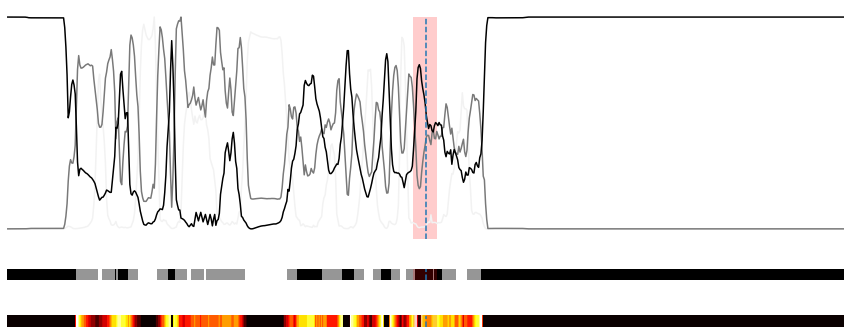

In [37]:
fig = plt.figure(figsize=(15,6))
gs1 = gridspec.GridSpec(3,1,height_ratios=np.array([1,1,0.1]))
gs1.update(wspace=0.4,hspace=-.5)

p1 = fig.add_subplot(gs1[0])
color = sns.light_palette('black', avg_norm.shape[1])
# color[0],color[1] = color[1],color[0]
# color.reverse()

for i in np.arange(0,avg_norm.shape[-1]):
    p1.plot(avg_norm[:,i], color=color[i])

format_graph()  
    
p2 = fig.add_subplot(gs1[1], sharex=p1)
p2.imshow(np.transpose(tissue),aspect=10,cmap=plt.cm.get_cmap('Greys_r', 3))

p3 = fig.add_subplot(gs1[2], sharex=p1)
p3.imshow(np.transpose(avg_layers),aspect=10,cmap='hot')

rect1 = patches.Rectangle((349,p1.axes.get_ylim()[0]),20,p1.axes.get_ylim()[1],linewidth=1,edgecolor=None,facecolor='r', alpha=0.2)
rect2 = patches.Rectangle((349,p2.axes.get_ylim()[0]),20,-50,linewidth=1,edgecolor=None,facecolor='r', alpha=0.2)
rect3 = patches.Rectangle((349,p3.axes.get_ylim()[0]),20,-50,linewidth=1,edgecolor=None,facecolor='r', alpha=0.2)

p1.add_patch(rect1)
p2.add_patch(rect2)
p3.add_patch(rect3)

# dashed line for center of line
p1.axvline(x=360,ymax=0.95, ls='--')
p2.axvline(x=360,ymax=0.95, ls='--')
p3.axvline(x=360,ymax=0.95, ls='--')

format_graph()
p1.axis('off')
p2.axis('off')
p3.axis('off')

fig.tight_layout()

plt.show()

In [38]:
roi = tissue[345:360]
start = np.where(roi == 1)[0][0] + 345
stop = np.where(roi == 1)[0][-1] + 345
diff = stop-start

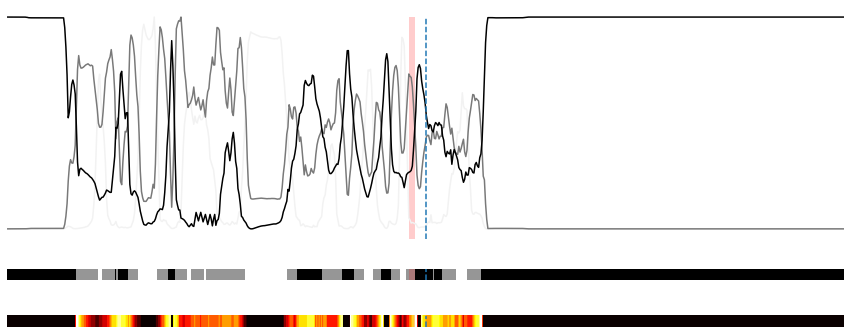

In [39]:
fig = plt.figure(figsize=(15,6))
gs1 = gridspec.GridSpec(3,1,height_ratios=np.array([1,1,0.1]))
gs1.update(wspace=0.4,hspace=-.5)

p1 = fig.add_subplot(gs1[0])
color = sns.light_palette('black', avg_norm.shape[1])
# color[0],color[1] = color[1],color[0]
# color.reverse()

for i in np.arange(0,avg_norm.shape[-1]):
    p1.plot(avg_norm[:,i], color=color[i])

format_graph()  
    
p2 = fig.add_subplot(gs1[1], sharex=p1)
p2.imshow(np.transpose(tissue),aspect=10,cmap=plt.cm.get_cmap('Greys_r', 3))

p3 = fig.add_subplot(gs1[2], sharex=p1)
p3.imshow(np.transpose(avg_layers),aspect=10,cmap='hot')

rect1 = patches.Rectangle((start,p1.axes.get_ylim()[0]),diff,p1.axes.get_ylim()[1],linewidth=1,edgecolor=None,facecolor='r', alpha=0.2)
rect2 = patches.Rectangle((start,p2.axes.get_ylim()[0]),diff,-50,linewidth=1,edgecolor=None,facecolor='r', alpha=0.2)
rect3 = patches.Rectangle((start,p3.axes.get_ylim()[0]),diff,-50,linewidth=1,edgecolor=None,facecolor='r', alpha=0.2)

p1.add_patch(rect1)
p2.add_patch(rect2)
p3.add_patch(rect3)

# dashed line for center of line
p1.axvline(x=360,ymax=0.95, ls='--')
p2.axvline(x=360,ymax=0.95, ls='--')
p3.axvline(x=360,ymax=0.95, ls='--')

format_graph()
p1.axis('off')
p2.axis('off')
p3.axis('off')

fig.tight_layout()

plt.show()

In [60]:
empty_img = np.zeros_like(nb.load(slc).get_fdata())
seg = tissue[:,np.newaxis]
empty_img[:,358:359] = tissue[:,np.newaxis]

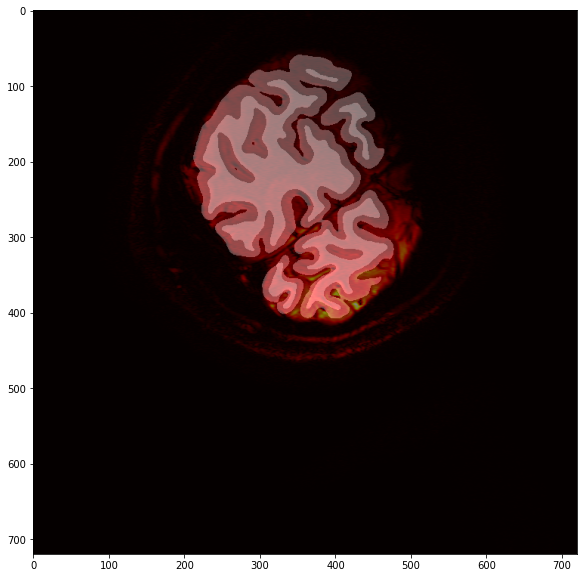

In [80]:
fig = plt.figure(figsize=(20,10))
im1 = plt.imshow(np.squeeze(nb.load(slc).get_fdata()), cmap='hot')
im2 = plt.imshow(np.squeeze(nb.load(resampled['cortex']).get_fdata()), alpha=0.5, cmap='Greys_r')
plt.show()

In [244]:
# # find in which direction all the values have the same value > that must be the line
# if np.all(np.around(line_data[:,360],3)==np.round(np.amax(line_data),3)):
#     print('left-to-right line')
#     line_wm  = resampled_wm.get_fdata()[:,360].reshape((720,1))#; line_tissue = np.array([round(num) for num in line_tissue]); line_tissue = line_tissue[...,None]
#     line_gm  = resampled_gm.get_fdata()[:,360].reshape((720,1))
#     line_csf = resampled_csf.get_fdata()[:,360].reshape((720,1))
    
# elif np.all(np.around(img_data[360,:],3)==np.round(np.amax(img_data),3)):
#     print('top-to-bottom line')
#     line_wm  = resampled_wm.get_fdata()[:,360].reshape((720,1))#; line_tissue = np.array([round(num) for num in line_tissue]); line_tissue = line_tissue[...,None]
#     line_gm  = resampled_gm.get_fdata()[:,360].reshape((720,1))
#     line_csf = resampled_csf.get_fdata()[:,360].reshape((720,1))
    
# wm_stack = np.tile(line_wm, (1,60))
# gm_stack = np.tile(line_gm, (1,60))
# csf_stack = np.tile(line_csf, (1,60))

### Plotting stuff

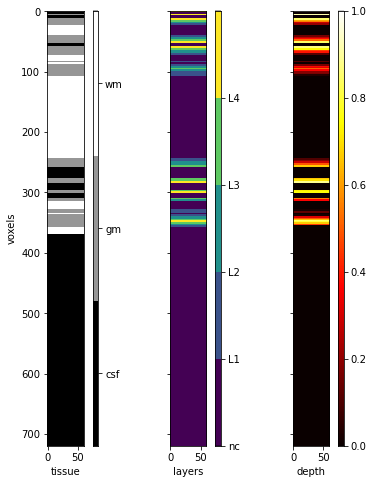

In [61]:
# plot PVE, discrete layers, and depth
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.axes_grid1 as axes_grid1

fig = plt.figure(figsize=(15,8),constrained_layout=True)
grid = axes_grid1.AxesGrid(
    fig, 111, nrows_ncols=(1,3), axes_pad=1, cbar_location="right",
    cbar_mode="each", cbar_size="15%", cbar_pad="25%",)

tissue_n = np.array(['csf', 'gm', 'wm'])
layers_n = np.array(['nc', 'L1', 'L2', 'L3', 'L4'])

im0 = grid[0].imshow(tissue_stack, cmap=plt.cm.get_cmap('Greys_r', 3), interpolation='nearest', vmin=0, vmax=2)
grid.cbar_axes[0].colorbar(im0,ticks=[2,1,0], format=plt.FuncFormatter(lambda val, loc: tissue_n[val]))
im1.set_clim(0,5)
grid[1].set_xlabel('layers')

im2 = grid[2].imshow(depth_stack, cmap='hot', interpolation='nearest', vmin=0, vmax=1)
grid.cbar_axes[2].colorbar(im2)
grid[2].set_xlabel('depth')

plt.show()
# grid.cbar_axes[2].colorbar(im1,ticks=[0,1,2,3,4], format=plt.FuncFormatter(lambda val, loc: layers_n[val]))
# im1.set_clim(0,5)

### Data selection for denoising and signal characterization

In [171]:
try:
    data = line.get_composite(opj(proj, 'derivatives', 'model_fitting', 'timecourses.csv'))
    onsets = line.get_composite(opj(proj, 'derivatives', 'model_fitting', 'onsets.csv'))
except:
    raise FileNotFoundError("run notebooks/hemifield_lineplanning.ipynb first")

In [172]:
data.head()

,run,t,vox 0,vox 1,vox 2,vox 3,vox 4,vox 5,vox 6,vox 7,...,vox 710,vox 711,vox 712,vox 713,vox 714,vox 715,vox 716,vox 717,vox 718,vox 719
subject,,,,,,,,,,,,,,,,,,,,,
1,1,0.000,0.303772,1.254632,0.753526,-0.675691,1.743052,-0.735998,-0.840172,-1.143773,...,-0.806033,-0.799308,-0.961436,1.206652,-0.561497,1.283229,0.112947,-1.157944,1.590362,0.891690
1,1,0.105,0.527489,-1.267660,0.784523,-1.256793,-0.630560,-0.394868,2.497997,0.262177,...,0.369895,-0.259674,0.134520,-0.412916,-0.189716,-1.123901,-0.279340,-0.067849,0.233701,0.072326
1,1,0.210,-0.086130,-1.386648,-1.454586,-0.582716,0.363332,0.241292,-1.557501,-1.055939,...,0.732940,0.762266,0.378104,0.645540,-1.366354,-0.054025,0.184741,1.187910,0.377914,0.358274
1,1,0.315,0.295945,-0.727788,-1.195555,0.021796,-1.735257,1.900156,-0.173622,1.011277,...,-0.742996,0.148519,1.364692,0.626124,-0.973269,0.209447,1.163907,-0.196324,0.104781,3.250227
1,1,0.420,-0.604244,0.631950,-0.040249,-1.551621,0.504673,0.737811,-0.796823,-0.122138,...,-1.639082,-1.010317,-0.507557,-0.829922,0.791078,-1.166530,0.223287,0.262787,-0.192591,0.181439


In [174]:
idx = np.where(line_layers==4)[0]
print(idx)
is_L4 = (line_layers==4).T

[  0   5   6  16  17  50  55  56  57  58  59  60  61 284 285 296 297 298
 299 300 346 347 348 349 350 351]


In [ ]:
wm_idx = np.where(line_tissue==4)[0]
print(idx)
is_L4 = (line_layers==4).T

In [175]:
data.iloc[:,3]

subject
1    1.254632
1   -1.267660
1   -1.386648
1   -0.727788
1    0.631950
       ...   
3    0.741714
3    0.289561
3    2.125004
3    0.482889
3   -0.685622
Name: vox 1, Length: 32688, dtype: float64

In [176]:
sub_df = data.reset_index()
sub = sub_df[(sub_df['subject'] == 1) & (sub_df['run'] == 1)]

sub

,subject,run,t,vox 0,vox 1,vox 2,vox 3,vox 4,vox 5,vox 6,...,vox 710,vox 711,vox 712,vox 713,vox 714,vox 715,vox 716,vox 717,vox 718,vox 719
0,1,1,0.000,0.303772,1.254632,0.753526,-0.675691,1.743052,-0.735998,-0.840172,...,-0.806033,-0.799308,-0.961436,1.206652,-0.561497,1.283229,0.112947,-1.157944,1.590362,0.891690
1,1,1,0.105,0.527489,-1.267660,0.784523,-1.256793,-0.630560,-0.394868,2.497997,...,0.369895,-0.259674,0.134520,-0.412916,-0.189716,-1.123901,-0.279340,-0.067849,0.233701,0.072326
2,1,1,0.210,-0.086130,-1.386648,-1.454586,-0.582716,0.363332,0.241292,-1.557501,...,0.732940,0.762266,0.378104,0.645540,-1.366354,-0.054025,0.184741,1.187910,0.377914,0.358274
3,1,1,0.315,0.295945,-0.727788,-1.195555,0.021796,-1.735257,1.900156,-0.173622,...,-0.742996,0.148519,1.364692,0.626124,-0.973269,0.209447,1.163907,-0.196324,0.104781,3.250227
4,1,1,0.420,-0.604244,0.631950,-0.040249,-1.551621,0.504673,0.737811,-0.796823,...,-1.639082,-1.010317,-0.507557,-0.829922,0.791078,-1.166530,0.223287,0.262787,-0.192591,0.181439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2719,1,1,285.495,-0.634400,0.603499,-1.853058,0.515738,0.520018,-0.509160,-0.388651,...,-1.277996,-1.165756,0.502537,-0.404994,0.054896,-1.133614,0.163977,-0.786974,-0.889878,-1.121397
2720,1,1,285.600,-0.075939,-1.087693,0.939759,0.676931,0.551472,-0.345674,1.443842,...,1.103271,1.885798,-0.951860,-0.571408,-0.743855,-1.543075,2.779193,-0.964800,-0.816267,0.460323
2721,1,1,285.705,1.118805,0.871138,1.224457,-0.822905,0.438953,0.635831,1.403968,...,0.388344,-1.362515,2.011463,-0.382806,-1.117546,0.781441,1.219260,-0.747656,-0.983169,1.374966
2722,1,1,285.810,1.130968,0.558168,0.240418,1.501849,-0.538108,0.965328,-0.532163,...,0.122945,-0.172149,-0.377692,0.011405,-0.274616,1.351722,0.195554,0.182019,-0.268827,0.784143


In [12]:
# layers = []
# for j in range(1,5):
    
#     idx = np.where(line_layers==j)[0]

#     df = []
    
#     for i in idx:
#         tmp = pd.DataFrame(sub.iloc[:,i+3], columns=[f'vox {i}'])
#         df.append(tmp)

#     df = pd.concat(df, axis=1)
#     df['subject'], df['run'], df['layer'] = 1,1,j
#     layers.append(df)
    
# layers = pd.concat(layers).set_index(['subject', 'run', 'layer']);